In [1]:
import pandas as pd
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc


C:\Users\Javi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random

def replace_ambiguous_bases(sequence):
    def resolve_ambiguity(code):
        if code == 'R':
            return random.choice(['A', 'G'])
        elif code == 'Y':
            return random.choice(['C', 'T'])
        elif code == 'S':
            return random.choice(['G', 'C'])
        elif code == 'W':
            return random.choice(['A', 'T'])
        elif code == 'K':
            return random.choice(['G', 'T'])
        elif code == 'M':
            return random.choice(['A', 'C'])
        elif code == 'B':
            return random.choice(['C', 'G', 'T'])
        elif code == 'D':
            return random.choice(['A', 'G', 'T'])
        elif code == 'H':
            return random.choice(['A', 'C', 'T'])
        elif code == 'V':
            return random.choice(['A', 'C', 'G'])
        elif code == 'N':
            return random.choice(['A', 'T', 'C', 'G'])
        else:
            return code  # If the code is not an ambiguity code, return the same code
    
    resolved_sequence = ''.join(resolve_ambiguity(base) for base in sequence)
    return resolved_sequence

In [3]:
def reverse_complement(sequence):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    reverse_seq = sequence[::-1]  # Reverse the sequence
    reverse_complement_seq = ''.join(complement[base] for base in reverse_seq)
    return reverse_complement_seq

def reverse_complement_list(sequence_list):
    reverse_complements = []
    for seq in sequence_list:
        reverse_complements.append(reverse_complement(seq))
    return reverse_complements

In [4]:
#This function gets the cgr for the sequences
def easy_cgr(dna_sequence):
  nucleotide_map = {
    "A": (1, 1),
    "T": (-1, -1),
    "C": (1, -1),
    "G": (-1, 1),
}
  values=[]
  point=(0,0)
  for nucleotide in dna_sequence:
        next_point=nucleotide_map[nucleotide]
        point=((point[0]+next_point[0])/2,(point[1]+next_point[1])/2)
        values.append(point)
  return values

In [5]:
#This function has input:
#sequence to plot that is the easy_cgr(sequence)
# plot id that is the name
# resolution that is the resolution
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plotting_cgr(sequence_to_plot,id_to_plot,resolution):

  # Define the resolution
  num_bins = resolution

  # Create a grid for the histogram
  xedges = np.linspace(-1, 1, num_bins + 1)
  yedges = np.linspace(-1, 1, num_bins + 1)

  # Create a 2D histogram
  hist, _, _ = np.histogram2d([p[0] for p in sequence_to_plot], [p[1] for p in sequence_to_plot], bins=[xedges, yedges])

  # Create a custom colormap spanning from light gray to dark gray
  colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
  cmap_name = "custom_gray"
  custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

  # Create a figure
  plt.figure()

  # Display the 2D histogram with the custom colormap
  plt.imshow(hist.T, cmap=custom_cmap, extent=[-1, 1, -1, 1], origin='lower', interpolation='nearest', aspect='auto')

  # Calculate coordinates for labels
  plt.xticks([])
  plt.yticks([])
  x_margin, y_margin = 0.05, 0.05
  label_coordinates = {
      "A": (1+ x_margin, 1 +y_margin),
      "T": (-1 - x_margin, -1-y_margin),
      "C": (1 + x_margin, -1 -y_margin),
      "G": (-1 - x_margin, 1 + y_margin),
  }

  # Add labels outside the grid
  for letter, (x, y) in label_coordinates.items():
      plt.text(x, y, letter, ha='center', va='center', fontsize=15, color='black')
  # Show the plot
  plt.title('CGR for '+id_to_plot)
  plt.grid(False)  # Turn off grid lines
  plt.show()

In [6]:
#This function reads the file when usingantibiotic resistance genes
import re

def read_antibiotic_resistance_genes(fasta_file_path):
    # Initialize lists to store sequence data
    sequence_ids = []
    sequences = []
    terms_inside_brackets = []  # Initialize a list to store terms inside brackets

    # Define a regular expression pattern to match text inside square brackets
    pattern = r'\[([^]]+)\]'

    # Open the FASTA file for reading
    with open(fasta_file_path, "r") as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace

            # Check if the line is an ID line (starts with '>')
            if line.startswith(">"):
                # If it's not the first sequence, process the previous one
                if sequence_ids:
                    term_inside_brackets = re.search(pattern, sequence_ids[-1]).group(1)
                    terms_inside_brackets.append(term_inside_brackets)  # Append to the list
                # Extract the sequence ID from the ID line
                sequence_ids.append(line[1:])
                sequences.append("")  # Reset the sequence
            else:
                # Append the line to the sequence
                sequences[-1] += line

    # Process the last sequence in the file
    if sequence_ids:
        term_inside_brackets = re.search(pattern, sequence_ids[-1]).group(1)
        terms_inside_brackets.append(term_inside_brackets)

    return sequences, terms_inside_brackets

In [7]:
from Bio import SeqIO

def read_fasta_patients(file_path):
    sequence_ids = []
    sequences = []
    
    try:
        with open(file_path, "r") as fasta_file:
            fasta_sequences = SeqIO.parse(fasta_file, "fasta")
            
            for seq_record in fasta_sequences:
                sequence_ids.append(seq_record.id)
                sequences.append(str(seq_record.seq))
    except FileNotFoundError:
        print("File not found. Please provide a valid file path.")
    
    return sequences, sequence_ids


In [8]:
#This function has input:
#sequence to plot that is the easy_cgr(sequence)
# plot id that is the name
# resolution that is the resolution
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plotting_cgr(sequence_to_plot,id_to_plot,resolution):

  # Define the resolution
  num_bins = resolution

  # Create a grid for the histogram
  xedges = np.linspace(-1, 1, num_bins + 1)
  yedges = np.linspace(-1, 1, num_bins + 1)

  # Create a 2D histogram
  hist, _, _ = np.histogram2d([p[0] for p in sequence_to_plot], [p[1] for p in sequence_to_plot], bins=[xedges, yedges])

  # Create a custom colormap spanning from light gray to dark gray
  colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
  cmap_name = "custom_gray"
  custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

  # Create a figure
  plt.figure()

  # Display the 2D histogram with the custom colormap
  plt.imshow(hist.T, cmap=custom_cmap, extent=[-1, 1, -1, 1], origin='lower', interpolation='nearest', aspect='auto')

  # Calculate coordinates for labels
  plt.xticks([])
  plt.yticks([])
  x_margin, y_margin = 0.05, 0.05
  label_coordinates = {
      "A": (1+ x_margin, 1 +y_margin),
      "T": (-1 - x_margin, -1-y_margin),
      "C": (1 + x_margin, -1 -y_margin),
      "G": (-1 - x_margin, 1 + y_margin),
  }

  # Add labels outside the grid
  for letter, (x, y) in label_coordinates.items():
      plt.text(x, y, letter, ha='center', va='center', fontsize=15, color='black')
  # Show the plot
  plt.title('CGR for '+id_to_plot)
  plt.grid(False)  # Turn off grid lines
  plt.show()


In [9]:
import random

def replace_ambiguous_bases(sequence):
    def resolve_ambiguity(code):
        if code == 'R':
            return random.choice(['A', 'G'])
        elif code == 'Y':
            return random.choice(['C', 'T'])
        elif code == 'S':
            return random.choice(['G', 'C'])
        elif code == 'W':
            return random.choice(['A', 'T'])
        elif code == 'K':
            return random.choice(['G', 'T'])
        elif code == 'M':
            return random.choice(['A', 'C'])
        elif code == 'B':
            return random.choice(['C', 'G', 'T'])
        elif code == 'D':
            return random.choice(['A', 'G', 'T'])
        elif code == 'H':
            return random.choice(['A', 'C', 'T'])
        elif code == 'V':
            return random.choice(['A', 'C', 'G'])
        elif code == 'N':
            return random.choice(['A', 'T', 'C', 'G'])
        else:
            return code  # If the code is not an ambiguity code, return the same code
    
    resolved_sequence = ''.join(resolve_ambiguity(base) for base in sequence)
    return resolved_sequence

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def generate_cgr_and_save(sequence_to_plot, kmeres, output_filename):
    # Define the resolution
    num_bins = 2 ** kmeres

    # Create a grid for the histogram
    xedges = np.linspace(-1, 1, num_bins + 1)
    yedges = np.linspace(-1, 1, num_bins + 1)

    # Create a 2D histogram
    hist, _, _ = np.histogram2d(
        [p[0] for p in sequence_to_plot],
        [p[1] for p in sequence_to_plot],
        bins=[xedges, yedges]
    )

    # Create a custom colormap spanning from light gray to dark gray
    colors = [(1, 1, 1), (0.2, 0.2, 0.2)]  # Light gray to dark gray
    cmap_name = "custom_gray"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=len(sequence_to_plot) + 1)

    # Create a square figure with the desired size in inches
    dpi = 100
    fig, ax = plt.subplots(figsize=(84 / dpi, 84 / dpi), dpi=dpi)

    # Plot the histogram using imshow and set the extent to specify the image size
    ax.imshow(
        hist.T,
        cmap=custom_cmap,
        origin='lower',
        extent=[-1, 1, -1, 1],  # Setting extent to create a 100x100 pixel image
        interpolation='nearest'  # Optional: adjust the interpolation method
    )

    # Turn off the axis
    ax.axis('off')

    # Save the figure directly as an image using matplotlib.pyplot.savefig
    plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.close()

# Your remaining function remains unchanged
def generate_and_save_cgr_images(sequences, ids, output_dir, kmeres):
    # Create the output directory if it doesn't exist
    

    for i, (sequence, label) in enumerate(zip(sequences, ids)):
        # Generate the image filename based on the class label and sequence index
        image_filename = os.path.join(output_dir, f"{i}_{label}.png")

        # Generate and save the CGR image
        generate_cgr_and_save(sequence, kmeres, image_filename)

In [11]:

def read_fasta_ARG(file_name):
    sequences = []
    with open(file_name, 'r') as file:
        sequence_id = ''
        sequence = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if sequence_id != '':
                    sequences.append(sequence_id.split('|') + [sequence])
                sequence_id = line[1:]
                sequence = ''
            else:
                sequence += line
        if sequence_id != '':
            sequences.append(sequence_id.split('|') + [sequence])
    return sequences

### Load images

### PATIENTS

In [53]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_1"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_1 = []
ids_patient_1 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_1.append(img_array)
    # Extract the label from the image filename
    ids_patient_1.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 10981


In [54]:
print( "these lenghts should be the same ",len(images_patient_1),", ",len(ids_patient_1))

these lenghts should be the same  10981 ,  10981


In [12]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_2"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_2 = []
ids_patient_2 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_2.append(img_array)
    # Extract the label from the image filename
    ids_patient_2.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 15000


In [13]:
print( "these lenghts should be the same ",len(images_patient_2),", ",len(ids_patient_2))

these lenghts should be the same  15000 ,  15000


In [57]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_4"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_4 = []
ids_patient_4 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_4.append(img_array)
    # Extract the label from the image filename
    ids_patient_4.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 9172


In [58]:
print( "these lenghts should be the same ",len(images_patient_4),", ",len(ids_patient_4))

these lenghts should be the same  9172 ,  9172


In [59]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_5"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_5 = []
ids_patient_5 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_5.append(img_array)
    # Extract the label from the image filename
    ids_patient_5.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 15000


In [60]:
print( "these lenghts should be the same ",len(images_patient_5),", ",len(ids_patient_5))

these lenghts should be the same  15000 ,  15000


In [14]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the paths to your dataset directories
dataset_dir_0 = "patient_6"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_patient_6 = []
ids_patient_6 = []  # List to store image labels
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_patient_6.append(img_array)
    # Extract the label from the image filename
    ids_patient_6.append(0)

# Now labels_patient_1 contains the labels for the images

Number of image files in the directory for label 0: 10267


In [15]:
print( "these lenghts should be the same ",len(images_patient_6),", ",len(ids_patient_6))

these lenghts should be the same  10267 ,  10267


# HEALTHY

In [63]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_14"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_14 = []
ids_healthy_14 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_14.append(img_array)
    # Extract the label from the image filename
    ids_healthy_14.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 10941


In [64]:
print( "these lenghts should be the same ",len(images_healthy_14),", ",len(ids_healthy_14))

these lenghts should be the same  10941 ,  10941


In [65]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_15"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_15 = []
ids_healthy_15 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_15.append(img_array)
    # Extract the label from the image filename
    ids_healthy_15.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 10741


In [66]:
print( "these lenghts should be the same ",len(images_healthy_15),", ",len(ids_healthy_15))

these lenghts should be the same  10741 ,  10741


In [16]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_16"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_16 = []
ids_healthy_16 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_16.append(img_array)
    # Extract the label from the image filename
    ids_healthy_16.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 4965


In [17]:
print( "these lenghts should be the same ",len(images_healthy_16),", ",len(ids_healthy_16))

these lenghts should be the same  4965 ,  4965


In [69]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_17"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_17 = []
ids_healthy_17 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_17.append(img_array)
    # Extract the label from the image filename
    ids_healthy_17.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 6671


In [70]:
print( "these lenghts should be the same ",len(images_healthy_17),", ",len(ids_healthy_17))

these lenghts should be the same  6671 ,  6671


In [18]:

# Define the paths to your dataset directories
dataset_dir_0 = "healthy_18"

# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_healthy_18 = []
ids_healthy_18 = []  # List to store image names
# Load and preprocess images from directory 0 (label 0)
image_files = os.listdir(dataset_dir_0)
print("Number of image files in the directory for label 0:", len(image_files))

for image_file in os.listdir(dataset_dir_0):
    # Load and preprocess the image
    img = load_img(os.path.join(dataset_dir_0, image_file), target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    # Append the image to the images list
    images_healthy_18.append(img_array)
    # Extract the label from the image filename
    ids_healthy_18.append(0)

    # Assuming you also have a list called labels, you need to define it somewhere in your code
    # labels.append(0)

# Now ids_patient_1 contains the names of the images

Number of image files in the directory for label 0: 9216


In [19]:
print( "these lenghts should be the same ",len(images_healthy_18),", ",len(ids_healthy_18))

these lenghts should be the same  9216 ,  9216


### Get datasets together

In [73]:
print("Length of images_healthy_18:", len(images_healthy_14))
print("Length of images_healthy_16:", len(images_healthy_15))
print("Length of images_patient_6:", len(images_patient_4))
print("Length of images_patient_2:", len(images_patient_5))

# Combine the images and IDs from different directories
images_data_1 = images_healthy_14 + images_healthy_15 + images_patient_4 + images_patient_5
labels_data_1 = ids_healthy_14 + ids_healthy_15 + ids_patient_4 + ids_patient_5

# Print lengths after combining
print("Length of images_combined:", len(images_data_1))
print("Length of ids_combined:", len(labels_data_1))

Length of images_healthy_18: 10941
Length of images_healthy_16: 10741
Length of images_patient_6: 9172
Length of images_patient_2: 15000
Length of images_combined: 45854
Length of ids_combined: 45854


In [74]:
print("Length of images_healthy_18:", len(images_healthy_17))
print("Length of images_healthy_16:", len(images_healthy_16))
print("Length of images_patient_6:", len(images_patient_6))
print("Length of images_patient_2:", len(images_patient_1))

# Combine the images and IDs from different directories
images_data_2 = images_healthy_16 + images_healthy_17 + images_patient_6 + images_patient_1
labels_data_2 = ids_healthy_16 + ids_healthy_17 + ids_patient_6 + ids_patient_1

# Print lengths after combining
print("Length of images_combined:", len(images_data_2))
print("Length of ids_combined:", len(labels_data_2))

Length of images_healthy_18: 6671
Length of images_healthy_16: 4965
Length of images_patient_6: 10267
Length of images_patient_2: 10981
Length of images_combined: 32884
Length of ids_combined: 32884


In [20]:
print("Length of images_healthy_18:", len(images_healthy_18))
print("Length of images_healthy_16:", len(images_healthy_16))
print("Length of images_patient_6:", len(images_patient_6))
print("Length of images_patient_2:", len(images_patient_2))

# Combine the images and IDs from different directories
images_data_3 = images_healthy_18 + images_healthy_16 + images_patient_2 + images_patient_6
labels_data_3 = ids_healthy_18 + ids_healthy_16 + ids_patient_2 + ids_patient_6

# Print lengths after combining
print("Length of images_combined:", len(images_data_3))
print("Length of ids_combined:", len(labels_data_3))

Length of images_healthy_18: 9216
Length of images_healthy_16: 4965
Length of images_patient_6: 10267
Length of images_patient_2: 15000
Length of images_combined: 39448
Length of ids_combined: 39448


### LOAD ARG

### PATIENT

In [76]:
dataset_dir_1 = "ARG_and_inv_conjugates_images_synthetic_patient"

In [77]:


# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_ARG_patient = []
labels_ARG_patient = []

In [78]:
# Load and preprocess images from directory 1 (label 1)
for image_file in os.listdir(dataset_dir_1): 
    # Check if the file is an image file
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Load and preprocess the image
        img = load_img(os.path.join(dataset_dir_1, image_file), target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        # Append the image and class label to the lists
        images_ARG_patient.append(img_array)
        labels_ARG_patient.append(1)
    else:
        print("Skipping non-image file:", image_file)



Skipping non-image file: k127_102740_2_H-NS_[Escherichia_coli_O157
Skipping non-image file: k127_131331_2_LEN-10_[Klebsiella_variicola_CAG
Skipping non-image file: k127_157721_2_mdtG_[Escherichia_coli_O139
Skipping non-image file: k127_184629_2_cpxA_[Escherichia_coli_O157
Skipping non-image file: k127_191508_2_Ecol_mipA_[Escherichia_coli_O157
Skipping non-image file: k127_213022_2_CARB-21_[Vibrio_parahaemolyticus_O1
Skipping non-image file: k127_214740_2_gadW_[Escherichia_coli_O25b
Skipping non-image file: k127_218408_2_Ecol_rpoB_RIF_[Escherichia_coli_O157
Skipping non-image file: k127_241503_2_rosB_[Yersinia_enterocolitica_(type_O
Skipping non-image file: k127_328239_2_Ecol_LamB_[Escherichia_coli_O157
Skipping non-image file: k127_75467_2_evgA_[Escherichia_coli_O157
Skipping non-image file: k127_75844_2_rosA_[Yersinia_enterocolitica_(type_O


### HEALTHY

In [79]:
dataset_dir_1 = "ARG_and_inv_conjugates_images_synthetic_healthy"

In [80]:


# Initialize empty lists to store images and labels
# Define image dimensions
img_height, img_width = 100, 100
images_ARG_healthy = []
labels_ARG_healthy = []

In [81]:
# Load and preprocess images from directory 1 (label 1)
for image_file in os.listdir(dataset_dir_1): 
    # Check if the file is an image file
    if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        # Load and preprocess the image
        img = load_img(os.path.join(dataset_dir_1, image_file), target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        # Append the image and class label to the lists
        images_ARG_healthy.append(img_array)
        labels_ARG_healthy.append(1)
    else:
        print("Skipping non-image file:", image_file)



Skipping non-image file: k127_109709_20_rosB_[Yersinia_enterocolitica_(type_O
Skipping non-image file: k127_116350_20_cpxA_[Escherichia_coli_O157
Skipping non-image file: k127_123106_20_LEN-10_[Klebsiella_variicola_CAG
Skipping non-image file: k127_14932_20_mdtG_[Escherichia_coli_O139
Skipping non-image file: k127_18335_20_H-NS_[Escherichia_coli_O157
Skipping non-image file: k127_26281_20_Ecol_mipA_[Escherichia_coli_O157
Skipping non-image file: k127_52869_20_Ecol_rpoB_RIF_[Escherichia_coli_O157
Skipping non-image file: k127_62274_20_evgA_[Escherichia_coli_O157
Skipping non-image file: k127_85824_20_rosA_[Yersinia_enterocolitica_(type_O
Skipping non-image file: k127_86092_20_gadW_[Escherichia_coli_O25b
Skipping non-image file: k127_8838_20_Ecol_LamB_[Escherichia_coli_O157
Skipping non-image file: k127_89106_20_CARB-21_[Vibrio_parahaemolyticus_O1


In [82]:
## put them together

In [83]:
images_ARG=images_ARG_patient+images_ARG_healthy
labels_ARG=labels_ARG_patient+labels_ARG_healthy

In [84]:
del images_ARG_patient
del labels_ARG_patient
del images_ARG_healthy
del labels_ARG_healthy

In [85]:
len(images_ARG)

20224

In [86]:
len(labels_ARG)

20224

### Final Dataset 1

In [87]:
# Convert lists to NumPy arrays
images_classification_1 = np.array(images_data_1+images_ARG)
labels_classification_1 = np.array(labels_data_1+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_classification_1))
print("Number of loaded labels:", len(labels_classification_1))
print("Sample class labels:", labels_classification_1[:5])

Number of loaded images: 66078
Number of loaded labels: 66078
Sample class labels: [0 0 0 0 0]


In [88]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_classification_1:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_classification_1))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 66078
Number of images with label 0: 45854
Number of images with label 1: 20224


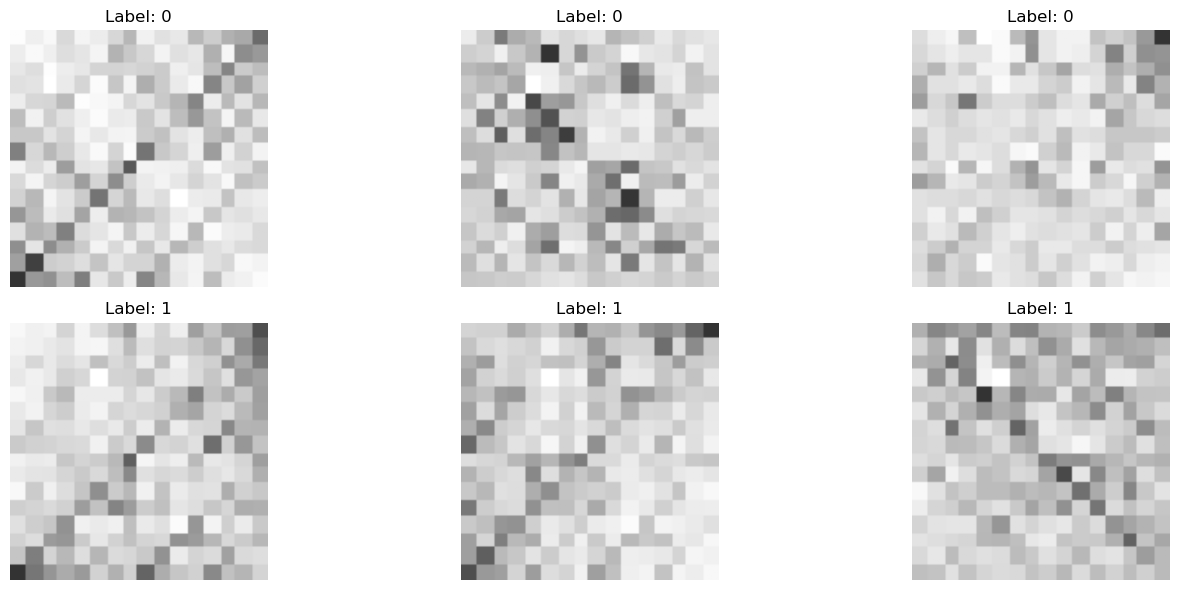

In [89]:
import matplotlib.pyplot as plt

# Define function to print images and labels for each label
def plot_images(images, labels, num_images_per_label=3):
    fig, axes = plt.subplots(2, num_images_per_label, figsize=(15, 6))
    for label in range(2):
        label_indices = [i for i, l in enumerate(labels) if l == label]
        for i in range(num_images_per_label):
            axes[label, i].imshow(images[label_indices[i]])
            axes[label, i].set_title("Label: {}".format(label))
            axes[label, i].axis('off')
    plt.tight_layout()
    plt.show()

# Print a few images for each label
plot_images(images_classification_1, labels_classification_1)



### Final Dataset 2

In [90]:
# Convert lists to NumPy arrays
images_classification_2 = np.array(images_data_2+images_ARG)
labels_classification_2 = np.array(labels_data_2+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_classification_2))
print("Number of loaded labels:", len(labels_classification_2))
print("Sample class labels:", labels_classification_2[:5])

Number of loaded images: 53108
Number of loaded labels: 53108
Sample class labels: [0 0 0 0 0]


In [91]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_classification_2:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_classification_2))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


Number of loaded images: 53108
Number of images with label 0: 32884
Number of images with label 1: 20224


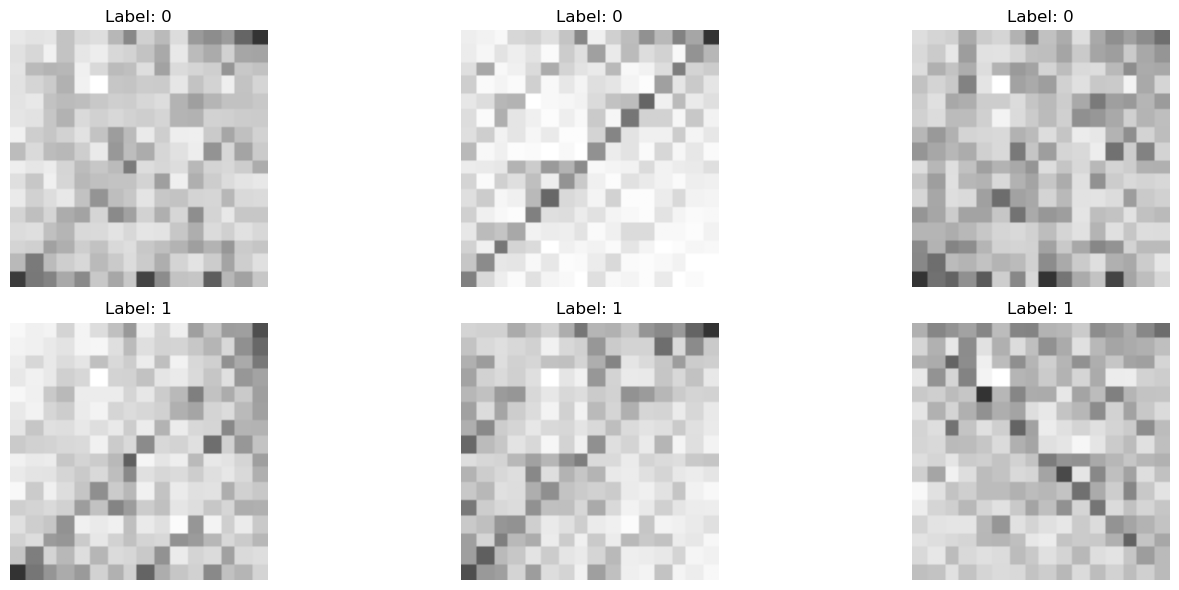

In [92]:


# Print a few images for each label
plot_images(images_classification_2, labels_classification_2)



### Final Dataset 3

In [93]:
# Convert lists to NumPy arrays
images_classification_3 = np.array(images_data_3+images_ARG)
labels_classification_3 = np.array(labels_data_3+labels_ARG)

# Debugging information
print("Number of loaded images:", len(images_classification_3))
print("Number of loaded labels:", len(labels_classification_3))
print("Sample class labels:", labels_classification_3[:5])

MemoryError: Unable to allocate 6.67 GiB for an array with shape (59672, 100, 100, 3) and data type float32

In [ ]:
# Count the number of images for each label
label_counts = {0: 0, 1: 0}
for label in labels_classification_3:
    label_counts[label] += 1

# Debugging information
print("Number of loaded images:", len(images_classification_3))
print("Number of images with label 0:", label_counts[0])
print("Number of images with label 1:", label_counts[1])


In [ ]:


# Print a few images for each label
plot_images(images_classification_3, labels_classification_3)



# Model 1: Data

In [39]:

train_images = images_classification_1
train_labels = labels_classification_1
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [40]:
del images_classification_1
del labels_classification_1

In [41]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 36720 samples
Label 1: 16142 samples
Total samples in the training set: 52862


In [42]:
# Generic

In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1652/1652 [==============================] - 270s 163ms/step - loss: 0.5387 - accuracy: 0.7343 - val_loss: 0.4749 - val_accuracy: 0.7804
Epoch 2/10
1652/1652 [==============================] - 266s 161ms/step - loss: 0.4524 - accuracy: 0.7919 - val_loss: 0.4324 - val_accuracy: 0.8039
Epoch 3/10
1652/1652 [==============================] - 257s 156ms/step - loss: 0.4085 - accuracy: 0.8156 - val_loss: 0.4056 - val_accuracy: 0.8192
Epoch 4/10
1652/1652 [==============================] - 273s 165ms/step - loss: 0.3828 - accuracy: 0.8281 - val_loss: 0.4134 - val_accuracy: 0.8121
Epoch 5/10
1652/1652 [==============================] - 262s 158ms/step - loss: 0.3634 - accuracy: 0.8370 - val_loss: 0.3901 - val_accuracy: 0.8280
Epoch 6/10
1652/1652 [==============================] - 251s 152ms/step - loss: 0.3469 - accuracy: 0.8460 - val_loss: 0.3814 - val_accuracy: 0.8313
Epoch 7/10
1652/1652 [==============================] - 252s 153ms/step - loss: 0.3337 - accuracy: 0.8520 - val_

In [44]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

413/413 [==============================] - 15s 35ms/step


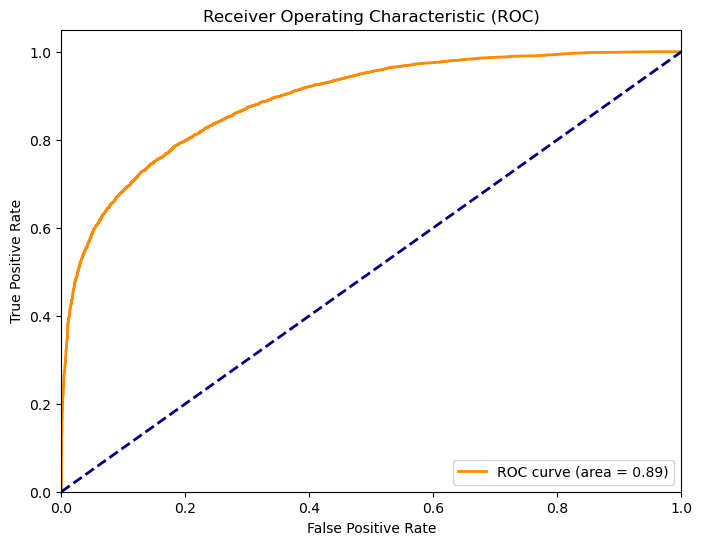

Accuracy: 0.8342
Precision: 0.8649
Recall: 0.5490
F1 Score: 0.6717
ROC-AUC Score: 0.8904


In [45]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

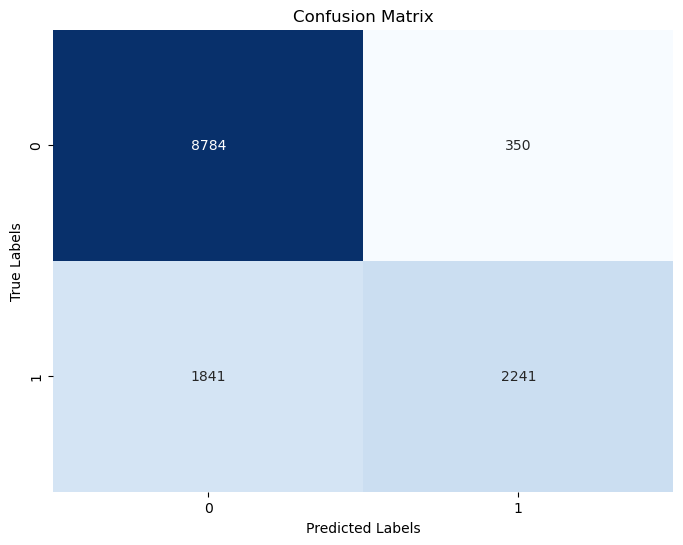

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Save the model
model_generic.save('generic_model_ARGvshealthy_and_patient_synthetic_1.h5')

# Model 2: Data

In [33]:

train_images = images_classification_2
train_labels = labels_classification_2
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [34]:
del images_classification_2
del labels_classification_2

In [35]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 26309 samples
Label 1: 16177 samples
Total samples in the training set: 42486


In [36]:
# Generic

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1328/1328 [==============================] - 212s 158ms/step - loss: 0.5767 - accuracy: 0.7009 - val_loss: 0.5240 - val_accuracy: 0.7472
Epoch 2/10
1328/1328 [==============================] - 211s 159ms/step - loss: 0.5024 - accuracy: 0.7569 - val_loss: 0.4931 - val_accuracy: 0.7658
Epoch 3/10
1328/1328 [==============================] - 211s 159ms/step - loss: 0.4681 - accuracy: 0.7819 - val_loss: 0.4642 - val_accuracy: 0.7804
Epoch 4/10
1328/1328 [==============================] - 206s 155ms/step - loss: 0.4430 - accuracy: 0.7915 - val_loss: 0.4446 - val_accuracy: 0.7939
Epoch 5/10
1328/1328 [==============================] - 209s 158ms/step - loss: 0.4232 - accuracy: 0.8044 - val_loss: 0.4354 - val_accuracy: 0.7975
Epoch 6/10
1328/1328 [==============================] - 206s 155ms/step - loss: 0.4076 - accuracy: 0.8149 - val_loss: 0.4372 - val_accuracy: 0.7938
Epoch 7/10
1328/1328 [==============================] - 210s 158ms/step - loss: 0.3957 - accuracy: 0.8178 - val_

In [38]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

332/332 [==============================] - 10s 29ms/step


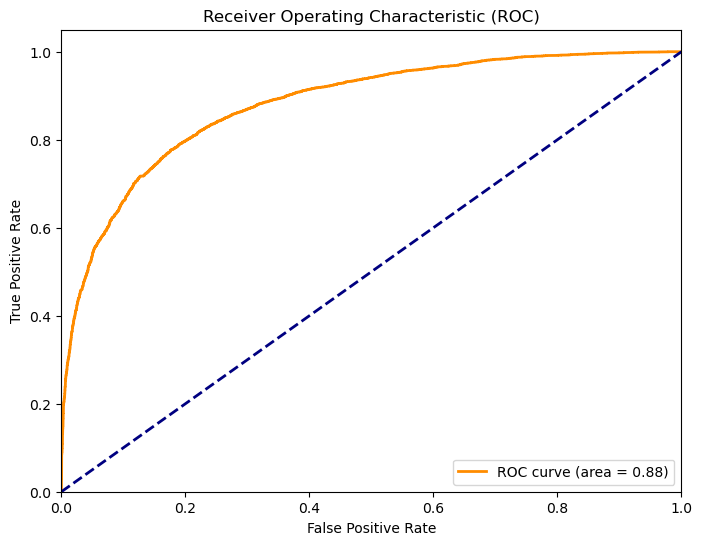

Accuracy: 0.8095
Precision: 0.7612
Recall: 0.7284
F1 Score: 0.7444
ROC-AUC Score: 0.8803


In [39]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

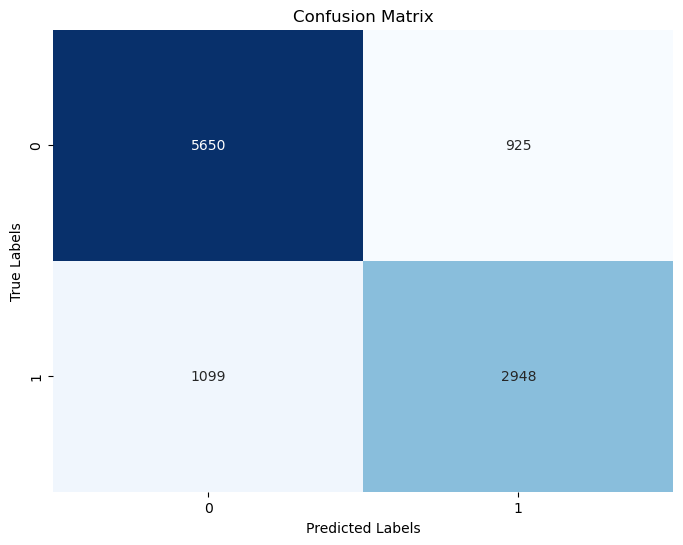

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [42]:
# Save the model
model_generic.save('generic_model_ARGvshealthy_and_patient_synthetic_2.h5')

# Model 3: Data

In [33]:

train_images = images_classification_3
train_labels = labels_classification_3
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [34]:
del images_classification_3
del labels_classification_3

In [35]:
# Count the occurrences of each label in y_train
unique_labels, label_counts = np.unique(y_train, return_counts=True)

# Print the counts of each label in y_train
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} samples")

# Optionally, you can also print the total number of samples in the training set
print(f"Total samples in the training set: {len(y_train)}")


Label 0: 31567 samples
Label 1: 16170 samples
Total samples in the training set: 47737


In [36]:
# Generic

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
# Set seed for NumPy
start_time = time.time()

np.random.seed(2007)

# Set seed for TensorFlow
tf.random.set_seed(2007)

# Define image dimensions
img_height, img_width = 100, 100

# Define the CNN model

model_generic = keras.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model_generic.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



# Train the model
epochs = 10
history = model_generic.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

# Evaluate the model on the validation set
test_loss, test_acc = model_generic.evaluate(X_test, y_test, verbose=2)
print("Validation accuracy:", test_acc)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the time taken
print(f"Time to generate model: {elapsed_time} seconds")

Epoch 1/10
1492/1492 [==============================] - 257s 172ms/step - loss: 0.5648 - accuracy: 0.7143 - val_loss: 0.4973 - val_accuracy: 0.7533
Epoch 2/10
1492/1492 [==============================] - 251s 168ms/step - loss: 0.4790 - accuracy: 0.7693 - val_loss: 0.5010 - val_accuracy: 0.7588
Epoch 3/10
1492/1492 [==============================] - 241s 162ms/step - loss: 0.4382 - accuracy: 0.7964 - val_loss: 0.4306 - val_accuracy: 0.7992
Epoch 4/10
1492/1492 [==============================] - 240s 161ms/step - loss: 0.4083 - accuracy: 0.8112 - val_loss: 0.4303 - val_accuracy: 0.7958
Epoch 5/10
1492/1492 [==============================] - 230s 154ms/step - loss: 0.3870 - accuracy: 0.8220 - val_loss: 0.4166 - val_accuracy: 0.8071
Epoch 6/10
1492/1492 [==============================] - 243s 163ms/step - loss: 0.3681 - accuracy: 0.8319 - val_loss: 0.4122 - val_accuracy: 0.8077
Epoch 7/10
1492/1492 [==============================] - 245s 164ms/step - loss: 0.3465 - accuracy: 0.8439 - val_

In [38]:
y_pred_prob=model_generic.predict(X_test)
y_pred = np.round(y_pred_prob)

# Calculate ROC-AUC score and plot ROC curve # Get predicted probabilities directly
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

373/373 [==============================] - 12s 31ms/step


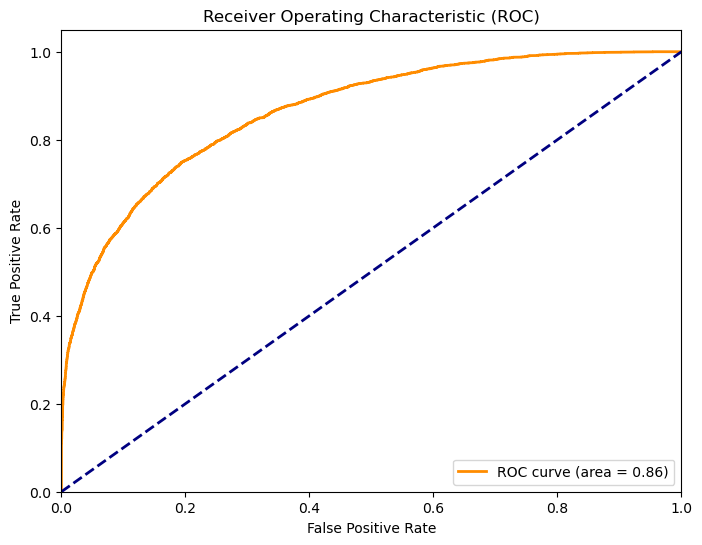

Accuracy: 0.8020
Precision: 0.7376
Recall: 0.6475
F1 Score: 0.6896
ROC-AUC Score: 0.8642


In [39]:

# Assuming you have already trained your model and have a set of predictions
# You can obtain predictions using model.predict(X_val) where X_val is your validation data



# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)



# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

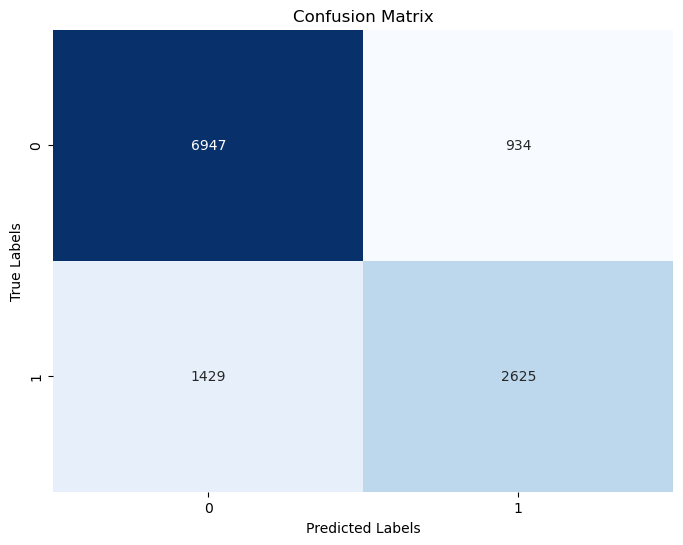

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
# Save the model
model_generic.save('generic_model_ARGvshealthy_and_patient_synthetic_3.h5')

C:\Users\Javi\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
